## Setup

In [1]:
!pip install poetry

In [2]:
!pip install https://github.com/swanandlab/SMorph/releases/download/0.1.0/SMorph-0.1.0.tar.gz

In [3]:
import warnings
warnings.filterwarnings('ignore')

import smorph as sm
import skimage
import matplotlib.pyplot as plt

In [4]:
def plot(img):
    plt.imshow(img)
    plt.show()

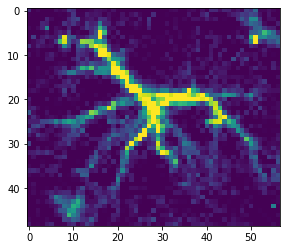

In [5]:
# path to a cell image (relative to Smorph folder) 
cell_image = skimage.io.imread("Datasets\CTRLvsSTAB\control\MAX_SW MICE 2_SEC 2_GFAP_RIGHT_CA1 _CONTRA_1-2_1.tif")
plot(cell_image)

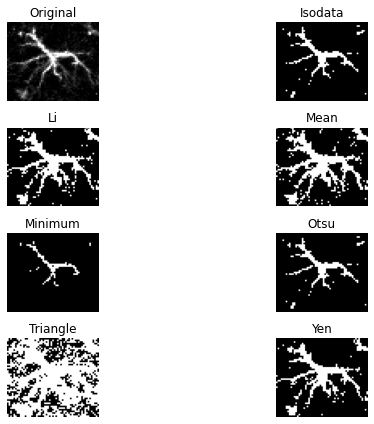

('isodata', 'li', 'mean', 'minimum', 'otsu', 'triangle', 'yen')

In [6]:
contrast_ptiles = (2, 98)

sm.util.try_all_threshold(cell_image, contrast_ptiles)
sm.util.THRESHOLD_METHODS

In [7]:
threshold_method = sm.util.THRESHOLD_METHODS[6]
threshold_method

'yen'

## Start single cell analysis

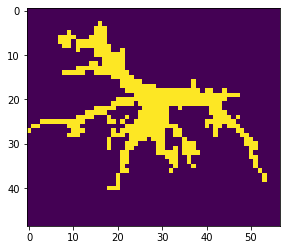

In [8]:
astrocyte = sm.Cell(cell_image, image_type='confocal', crop_tech='manual',
                    contrast_ptiles=contrast_ptiles,
                    threshold_method=threshold_method)
plot(astrocyte.cleaned_image)

In [9]:
astrocyte.features

{'surface_area': 413,
 'total_length': 180,
 'avg_process_thickness': 2.3,
 'convex_hull': 1320,
 'no_of_forks': 13,
 'no_of_primary_branches': 3,
 'no_of_secondary_branches': 7,
 'no_of_tertiary_branches': 12,
 'no_of_quatenary_branches': 9,
 'no_of_terminal_branches': 19,
 'avg_length_of_primary_branches': 5.3,
 'avg_length_of_secondary_branches': 6.7,
 'avg_length_of_tertiary_branches': 4.7,
 'avg_length_of_quatenary_branches': 5.6,
 'avg_length_of_terminal_branches': 5.2,
 'critical_radius': 12,
 'critical_value': 8.12,
 'enclosing_radius': 27,
 'ramification_index': 2.71,
 'skewness': -0.35,
 'coefficient_of_determination': 0.93,
 'sholl_regression_coefficient': 0.11,
 'regression_intercept': -1.1}

In [10]:
astrocyte.features['surface_area']

413

## Skeleton Analysis

In [11]:
# Sum of highlighted pixels is calculated to get the skeleton area estimate
astrocyte.features['total_length']

180

In [12]:
# Sum of highlighted pixels is calculated to get the area estimate of astrocyte
astrocyte.features['avg_process_thickness']

2.3

1320

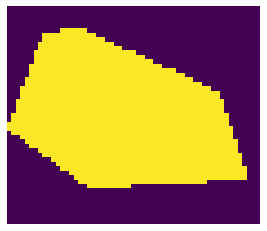

In [13]:
# Sum of pixels included in the smallest convex polygon that surround all astrocyte pixels
astrocyte.plot_convex_hull()
astrocyte.features['convex_hull']

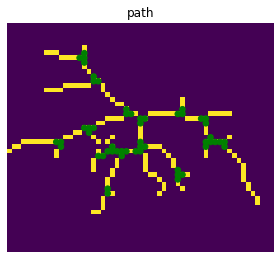

13

In [14]:
# Count all the bifurcation points
astrocyte.plot_forks()
astrocyte.features['no_of_forks']

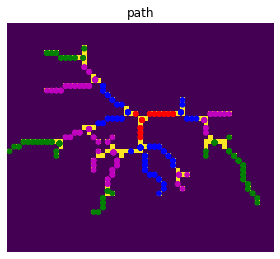

In [15]:
# The branches are differentiated into primary, secondary and further levels to compare any branch level differences between astrocytes
astrocyte.plot_branching_structure()

## Sholl Analysis

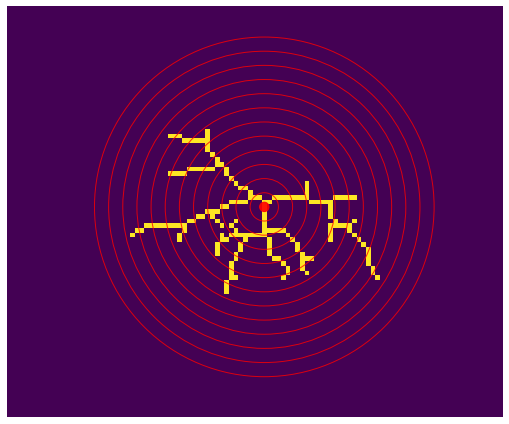

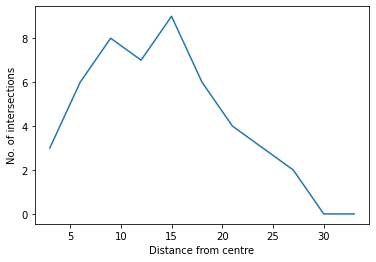

In [16]:
# Number of intersections of astrocytic branches at regular distances from the soma
astrocyte.plot_sholl_results()

Polynomial regression is used to mitigate the influence of local variations in the sampled data, and thereby better describe the relationship between intersections vs. distance

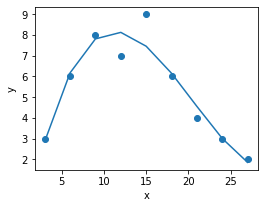

In [17]:
astrocyte.plot_polynomial_fit()

In [18]:
# Distance at which Critical value occurs (distance at which the Highest count of intersections occurred)
astrocyte.features['critical_radius']

12

In [19]:
# # Local maximum of the polynomial fit (Maximum no. of intersections)
astrocyte.features['critical_value']

8.12

In [20]:
# The last (thus, the widest) of intersecting radii to be associated with the number of intersections
astrocyte.features['enclosing_radius']

27

In [21]:
# Indication of how symmetrical the distribution is around its mean
astrocyte.features['skewness']

-0.35

In [22]:
# Ratio between critical value and number of primary branches
astrocyte.features['ramification_index']

2.71

In [23]:
# how close the data are to the fitted regression (indicative of the level of explained variability in the data set)
astrocyte.features['coefficient_of_determination']

0.93

In [24]:
# Rate of decay of no. of branches
astrocyte.features['sholl_regression_coefficient']

0.11

In [25]:
# Y intercept of the logarithmic plot
astrocyte.features['regression_intercept']

-1.1